In [201]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.graphics.tsaplots
from scipy import stats

In [202]:
sns.set(style='whitegrid', palette="Set2", color_codes=True)
%matplotlib inline

In [203]:
Project_Dir = os.getcwd()
Processed_Data_Dir = Project_Dir + r"/Processed_Data"

In [204]:
DATA_UNDLY=pd.read_csv(Processed_Data_Dir+'/Underlyings.csv',usecols=np.arange(1,6),parse_dates=['Date'])

In [205]:
DATA_UNDLY.shape

(4938, 5)

In [206]:
DATA_UNDLY.head()

,Date,Close,Fig,Ten_ma,pct_chg
0,2015-08-20,287.5,GASL,355.7,-0.066558
1,2015-08-21,261.5,GASL,350.3,-0.090435
2,2015-08-24,216.0,GASL,332.7,-0.173996
3,2015-08-25,205.5,GASL,316.1,-0.048611
4,2015-08-26,227.0,GASL,296.7,0.104623


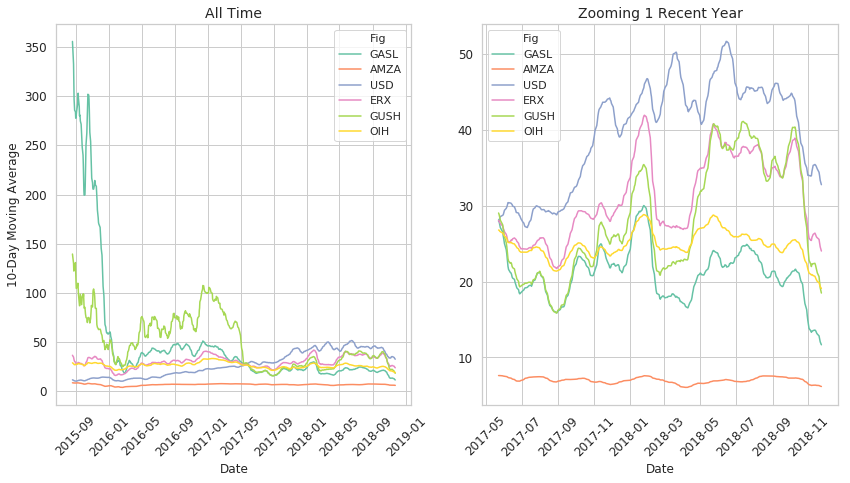

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(data=DATA_UNDLY,hue='Fig',y='Ten_ma',x='Date',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(ylabel='10-Day Moving Average',title='All Time')

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>="2017-5-23"],hue='Fig',y='Ten_ma',x='Date',ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(ylabel='',title='Zooming 1 Recent Year')
for ax in ax:
    for item in ([ax.yaxis.label,ax.xaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#     ax.set(title='Suggested Weight Adjustment For KAM\'s Features\n')
    # ax.xaxis.label.set_fontsize(13)
    ax.title.set_fontsize(14)
# plt.show()

In [208]:
dt_undly=DATA_UNDLY.loc[DATA_UNDLY.Date>="2017-5-23"]

* Get Rid of underlyings with low volatility

* Vecotrize Prices w.r.t each Underlying

In [209]:
data_close_pvt=dt_undly[['Date','Close','Fig']].pivot(index='Date',columns='Fig')
data_close_pvt.columns=data_close_pvt.columns.droplevel(0)

In [210]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2017-05-23,7.66,28.25,27.89,28.92,27.03,28.66
2017-05-24,7.63,27.86,26.63,27.88,26.77,29.06
2017-05-25,7.58,26.32,24.91,25.62,25.45,29.41
2017-05-26,7.55,26.36,25.15,25.84,25.59,29.67
2017-05-30,7.40,25.37,23.08,23.64,25.13,29.86


# Test GBM's Assumption 

### Auto Correlation

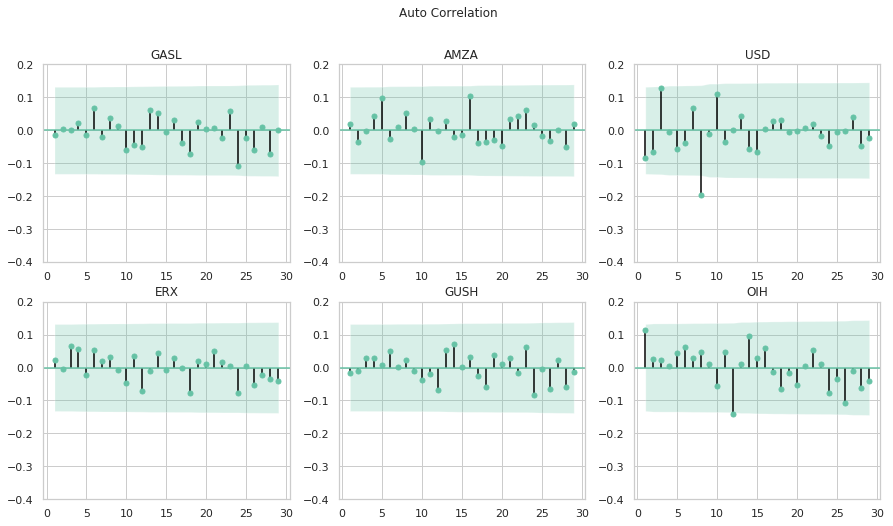

In [211]:
nrow,ncol,ax_ind=2, 3,0
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Auto Correlation')
gs1 = gridspec.GridSpec(nrow,ncol)
ax_ls = [fig.add_subplot(ss) for ss in gs1]
for fig in dt_undly.Fig.unique():
    ax=ax_ls[ax_ind]
    statsmodels.graphics.tsaplots.plot_acf(x=dt_undly[dt_undly.Fig==fig].pct_chg,unbiased=False, lags=np.arange(1,30)
                                           ,alpha=0.01,ax=ax)
    ax.set(title=fig,ylim=(-0.4,0.2))
    ax_ind+=1

In [212]:
col_indept=['GASL', 'AMZA', 'USD', 'ERX', 'GUSH', 'OIH']

# Generate Underlying Price 

### Assumptions and Preparations

* (Projection) Sample Path Span, Based on Options Availability

In [213]:
DATA_OPT=pd.read_csv(Processed_Data_Dir+'/Options.csv',index_col=[0],parse_dates=['Maturity','D2M'])

DATA_OPT.D2M=pd.to_timedelta(DATA_OPT.D2M)

In [214]:
DATA_OPT.head()

,Maturity,Fig,Strike,Bid_p,Ask_p,D2M
5,2018-12-21,GASL,6.0,0.05,0.15,28 days
6,2018-12-21,GASL,7.0,0.15,0.25,28 days
7,2018-12-21,GASL,8.0,0.35,0.45,28 days
8,2018-12-21,GASL,9.0,0.65,0.80,28 days
16,2019-01-18,GASL,9.0,1.00,1.20,56 days


In [215]:
DATA_OPT.loc[DATA_OPT.Fig.isin(col_indept)].groupby(['D2M','Fig'],group_keys=False).agg({'Fig':'count'})

Fig
D2M      Fig      
14 days  ERX    12
         OIH     5
21 days  ERX    14
         OIH     6
25 days  GUSH    1
28 days  AMZA    1
         ERX    16
         GASL    4
         GUSH    6
         OIH     7
         USD     9
35 days  ERX    14
         OIH     8
42 days  ERX    17
         OIH     8
49 days  ERX    16
         OIH     9
56 days  AMZA    1
         ERX     4
         GASL    1
         GUSH    8
         OIH     5
         USD    12
84 days  ERX    11
         GASL    5
         GUSH    7
         USD    12
112 days AMZA    1
         GASL    1
         GUSH    2
146 days ERX     7
         OIH     7
175 days USD     7
210 days GUSH    3
420 days GUSH    3
784 days GUSH    3

* Make an Assumption on Projection Span: **Days to Matuarity <= 56 Days**

In [216]:
Gen_Span=pd.Timedelta(56,'D')

In [217]:
dt_option=DATA_OPT[DATA_OPT.D2M<=Gen_Span]

In [218]:
dt_option.shape,dt_option.columns

((184, 6),
 Index(['Maturity', 'Fig', 'Strike', 'Bid_p', 'Ask_p', 'D2M'], dtype='object'))

* Historical Growth rate Vector for each Underlying

In [219]:
dt_gamma=data_close_pvt.pct_change()
dt_gamma.head()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2017-05-23,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-24,-0.003806,-0.013884,-0.045177,-0.035949,-0.009712,0.013876
2017-05-25,-0.006686,-0.055262,-0.064589,-0.081033,-0.049037,0.012203
2017-05-26,-0.003846,0.001490,0.009635,0.008584,0.005348,0.008789
2017-05-30,-0.020270,-0.037203,-0.082306,-0.085106,-0.017857,0.006478


* Hostory Growth Mean and Cov, nTrial for Simulation

In [220]:
nTrial=10000
Gen_Mean,Gen_Cov=dt_gamma.mean(),dt_gamma.cov()

In [221]:
Gen_Mean,Gen_Cov

(Fig
 AMZA   -0.000556
 ERX    -0.000145
 GASL   -0.001505
 GUSH   -0.000238
 OIH    -0.000898
 USD     0.000687
 dtype: float64,
 Fig       AMZA       ERX      GASL      GUSH       OIH       USD
 Fig                                                             
 AMZA  0.000210  0.000325  0.000494  0.000512  0.000147  0.000157
 ERX   0.000325  0.001167  0.001441  0.001646  0.000517  0.000427
 GASL  0.000494  0.001441  0.002334  0.002483  0.000694  0.000533
 GUSH  0.000512  0.001646  0.002483  0.002804  0.000783  0.000593
 OIH   0.000147  0.000517  0.000694  0.000783  0.000287  0.000166
 USD   0.000157  0.000427  0.000533  0.000593  0.000166  0.000947)

### Simulate Underlyings, GBM

* Multinormal Growth Matrix,-sim_gamma

In [283]:
# sim_gamma=np.random.multivariate_normal(mean=Gen_Mean,cov=Gen_Cov,size=(nTrial,Gen_Span.days))
def sample_signal(n_samples, Gen_Mean, Gen_Cov):
    
    Gen_Cov_copy = Gen_Cov.copy()
    auto_corr = np.diag(Gen_Cov)
    Gen_Cov_copy.values[[np.arange(6)]*2] = 1

    c = Gen_Mean * (1 - auto_corr)
    sigma_e = np.sqrt((Gen_Cov_copy ** 2) * (1 - auto_corr ** 2))
    
    sigma_e.values[[np.arange(6)]*2] = auto_corr
    # Sample the auto-regressive process. !!!!!!!!!!!!! Need to initialize with the last value !!!!!!!!!!!!!!!!!
    signal = [c + np.random.multivariate_normal(mean=[0]*6,cov=sigma_e,size=1)[0]]
    for _ in range(1, n_samples):
        signal.append(c + auto_corr * signal[-1] + np.random.multivariate_normal(mean=[0]*6,cov=sigma_e,size=1)[0])
           
    return np.array(signal)

In [284]:
df = pd.DataFrame(sample_signal(nTrial, Gen_Mean, Gen_Cov))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


In [285]:
((Gen_Cov.values-df.cov().values)**2).sum()

1.0717667978137992e-09

In [286]:
sim=[]
for i in range(nTrial):
    sim.append(sample_signal(Gen_Span.days, Gen_Mean, Gen_Cov))
sim_gamma = np.array(sim)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


In [287]:
sim_gamma.shape

(10000, 56, 6)

In [288]:
sim_gamma=dict(zip(dt_gamma.columns.tolist(),[sim_gamma[:,:,fig] for fig in range(sim_gamma.shape[2])]))

In [289]:
sim_gamma['GUSH'].shape

(10000, 56)

In [290]:
sim_undly={}
sim_factor={}
for key,val in sim_gamma.items():
    sim_factor[key]=(val+1)
    s0=data_close_pvt[key][-1]
    cum_g=sim_factor[key].cumprod(axis=1)
    sim_undly[key]=s0*cum_g

* Visualize Smaple Path

In [291]:
class sim_result:
    def __init__(self, sim_undly):
        self.underlying=sim_undly
        self.max=sim_undly[list(sim_undly.keys())[0]].shape[0]
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n <= self.max:
            sim_undly0={}
            for key,val in self.underlying.items():
                sim_undly0[key]=val[self.n]
            sim_undly0=pd.DataFrame(sim_undly0)
            sim_undly0_longform=sim_undly0.reset_index().melt(id_vars=['index'],var_name='fig',value_name='close')
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
            self.n += 1
            print(self.n)
        else:
            raise StopIteration

In [292]:
sim_iter=iter(sim_result(sim_undly))

1


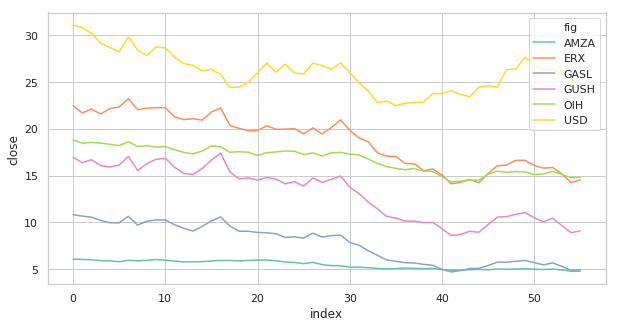

In [293]:
next(sim_iter)

### Net Income for Each Option

In [294]:
option_slct=DATA_OPT.loc[DATA_OPT.Fig.isin(sim_undly.keys()) & (DATA_OPT.D2M<=Gen_Span)]

In [295]:
option_slct.describe()

,Strike,Bid_p,Ask_p,D2M
count,184.000000,184.000000,184.000000,184
mean,18.861413,0.627065,0.862120,36 days 05:44:20.869565
std,5.329173,0.554789,0.733006,13 days 10:57:27.134394
min,6.000000,0.010000,0.050000,14 days 00:00:00
25%,16.000000,0.200000,0.300000,28 days 00:00:00
50%,18.000000,0.450000,0.600000,35 days 00:00:00
75%,22.000000,0.935000,1.200000,49 days 00:00:00
max,34.000000,2.250000,4.500000,56 days 00:00:00


In [296]:
option_slct.loc[option_slct.Fig=='OIH'].head()

,Maturity,Fig,Strike,Bid_p,Ask_p,D2M
38,2018-12-07,OIH,16.0,0.02,0.05,14 days
39,2018-12-07,OIH,16.5,0.07,0.08,14 days
40,2018-12-07,OIH,17.0,0.14,0.16,14 days
41,2018-12-07,OIH,17.5,0.27,0.29,14 days
42,2018-12-07,OIH,18.0,0.46,0.48,14 days


In [297]:
def output(sim_undly,option_slct,fig,strike,price,d2m,sh=100):
    st=sim_undly[fig][:,d2m-1]
    
    opt_combo=option_slct.loc[(option_slct.Fig==fig)
                              &(option_slct.Strike==strike)
                              &(option_slct.Ask_p==price)
                              &(option_slct.D2M==pd.Timedelta(d2m,'D'))]
    ni=price-np.maximum(0,strike-st)*sh
    return ni

In [298]:
def plot_opt(series, title):
#     figsize=(10, 8)
    series=series/1
    fig, ax = plt.subplots()
    sns.distplot((series).tolist(), bins=30, kde=False, ax=ax,
                 hist_kws={
                     # "color": sns.xkcd_rgb['azure'],
                     'weights': [1 / len(series)] * len(series)
                 })
    second_ax = ax.twinx()
    sns.distplot((series).tolist(), ax=second_ax, kde=True, hist=False,
                 kde_kws={
                     # "color": sns.xkcd_rgb['irish green'],
                     "label": "KDE"
                 })
    second_ax.set_yticks([])
    ax.hist((series).tolist(), bins=15, weights=[1 / len(series)] * len(series))
    ymin,ymax= ax.get_ylim()
    ax.vlines(x=0, ymin=ymin, ymax=ymax, colors=sns.xkcd_rgb['red orange'], linestyles='dashdot')
    ax.get_xaxis().get_major_formatter().set_powerlimits((-3, 4))
    ax.set_title(title, fontdict={'fontsize': '16'})
    ax.set(ylabel='Empirical Density (Mass)', xlabel='Ending Cash (in Thousands)')
    #
#     for item in ([ax.xaxis.label, ax.yaxis.label] +
#                  ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(16)
    plt.legend()
    plt.show()
    plt.clf()

In [299]:
output_sim_result=option_slct.copy()
output_Sim_ni={}

In [300]:
rf_1y=0.026

In [301]:
for idx in output_sim_result.index:
    fig,strike, price,d2m=output_sim_result.loc[idx,['Fig','Strike','Ask_p','D2M']]
    st=sim_undly[fig][:,d2m.days-1]
    ni=price-np.maximum(0,strike-st)*np.exp(-rf_1y*d2m.days/365)
    output_sim_result.loc[idx,'Mean_Ret']=ni.mean()
    output_sim_result.loc[idx,'Pr_Neg']=(ni<0).mean()
    output_sim_result.loc[idx,'VaR_5Pct']=-np.minimum(np.quantile(ni,0.05),0)
    output_Sim_ni[idx]=ni

In [302]:
output_sim_result[output_sim_result.Pr_Neg<1].sort_values('Mean_Ret',ascending=False).head(15)

,Maturity,Fig,Strike,Bid_p,Ask_p,D2M,Mean_Ret,Pr_Neg,VaR_5Pct
163,2019-01-18,AMZA,6.0,0.10,4.50,56 days,4.123054,0.0000,-0.000000
423,2019-01-18,USD,24.0,0.10,2.10,56 days,1.803201,0.0568,0.246391
421,2019-01-18,USD,22.0,0.05,1.20,56 days,1.079763,0.0345,-0.000000
424,2019-01-18,USD,25.0,0.20,1.15,56 days,0.713463,0.1149,2.192410
425,2019-01-18,USD,26.0,0.20,1.20,56 days,0.581855,0.1510,3.138429
71,2018-12-28,OIH,14.5,0.01,0.39,35 days,0.375763,0.0137,-0.000000
410,2018-12-21,USD,26.0,0.10,0.60,28 days,0.339313,0.1030,1.461665
266,2019-01-18,ERX,15.0,0.20,0.45,56 days,0.264711,0.0909,1.062940
123,2018-12-21,GUSH,14.0,1.10,1.30,28 days,0.262685,0.2937,3.348623
121,2018-12-21,GUSH,12.0,0.50,0.65,28 days,0.261209,0.1722,2.002608


In [303]:
output_sim_result.index.duplicated().sum()

0

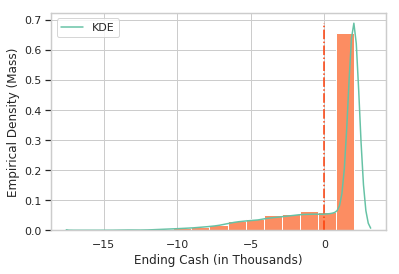

<Figure size 432x288 with 0 Axes>

In [304]:
plot_opt(output_Sim_ni[429],'')

### Finalization

In [305]:
import pickle

In [306]:
pickle.dump(output_sim_result,open(Processed_Data_Dir+'/Dash_Sim_Result.p', "wb" ))
pickle.dump(output_Sim_ni,open(Processed_Data_Dir+'/Dash_Sim_Ni.p', "wb" ))